<a href="https://colab.research.google.com/github/Tichow/TP_IA_embarquee/blob/main/TP_IA_EMBARQUEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [4]:
# Import all required libraries for deep learning predictive maintenance model
# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set visual style for plots
plt.style.use('tableau-colorblind10')
sns.set_context("notebook", font_scale=1.2)

from google.colab import drive

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

**QUESTION:** Load dataset and display some lines of the csv file.

In [5]:
# Load and explore the AI4I 2020 Predictive Maintenance Dataset

# Load dataset from CSV file
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/data/ai4i2020.csv'
maintenance_data = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset shape:", maintenance_data.shape)
print("\nDataset columns:", maintenance_data.columns.tolist())
print("\nSample data - first row:")
print(maintenance_data.iloc[0])
print("\nSample data - row 150:")
print(maintenance_data.iloc[150])

# Quick check for missing values
missing_values = maintenance_data.isnull().sum().sum()
print(f"\nTotal missing values in dataset: {missing_values}")

# Display dataset statistics summary
print("\nDataset summary statistics:")
maintenance_data.describe().round(2)

Mounted at /content/drive
Dataset shape: (10000, 14)

Dataset columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Sample data - first row:
UDI                             1
Product ID                 M14860
Type                            M
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]       1551
Torque [Nm]                  42.8
Tool wear [min]                 0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 0, dtype: object

Sample data - row 150:
UDI                           151
Product ID                 L47330
Type                            L
Air temperature [K]         298.4
Process temperature [K]     308.3
Rotational speed

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,300.0,310.01,1538.78,39.99,107.95,0.03,0.00,0.01,0.01,0.01,0.00
std,2886.90,2.0,1.48,179.28,9.97,63.65,0.18,0.07,0.11,0.10,0.10,0.04
min,1.00,295.3,305.70,1168.00,3.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2500.75,298.3,308.80,1423.00,33.20,53.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,5000.50,300.1,310.10,1503.00,40.10,108.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7500.25,301.5,311.10,1612.00,46.80,162.00,0.00,0.00,0.00,0.00,0.00,0.00
max,10000.00,304.5,313.80,2886.00,76.60,253.00,1.00,1.00,1.00,1.00,1.00,1.00


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64
Imbalance ratio (functional:failure): 28.50:1


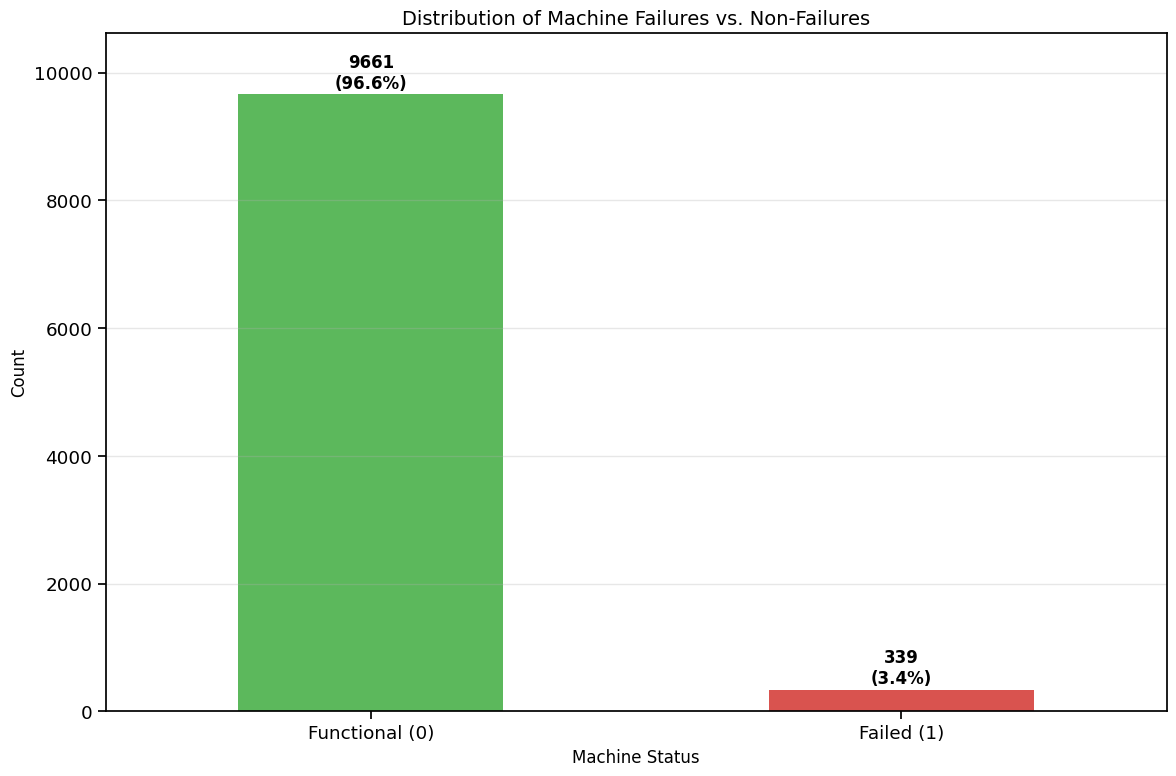


Observation: The dataset is highly imbalanced with significantly more
functional machines (9661 instances) than failed machines
(339 instances). This class imbalance will need to be
addressed during model training to prevent bias toward the majority class.


In [6]:
# Visualize the distribution of machine failures and non-failures

# Count the occurrences of failures and non-failures
failure_counts = maintenance_data["Machine failure"].value_counts()
print("Machine failure distribution:")
print(failure_counts)

# Calculate the imbalance ratio
imbalance_ratio = failure_counts[0] / failure_counts[1]
print(f"Imbalance ratio (functional:failure): {imbalance_ratio:.2f}:1")

# Create a bar plot to visualize the distribution
plt.figure(figsize=(12, 8))  # Make the figure larger
ax = failure_counts.plot(kind='bar', color=['#5cb85c', '#d9534f'])
plt.xlabel('Machine Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Machine Failures vs. Non-Failures', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Functional (0)', 'Failed (1)'], rotation=0)

# Add count and percentage labels above each bar with increased padding
total = failure_counts.sum()
for i, count in enumerate(failure_counts):
    percentage = count / total * 100
    # Increase vertical padding for the label
    plt.text(i, count + (total * 0.01), f"{count}\n({percentage:.1f}%)",
             ha='center', fontweight='bold', fontsize=12)

# Adjust y-axis limit to make room for labels
plt.ylim(0, max(failure_counts) * 1.1)  # Add 10% more space above the tallest bar

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analysis of class imbalance
print("\nObservation: The dataset is highly imbalanced with significantly more")
print(f"functional machines ({failure_counts[0]} instances) than failed machines")
print(f"({failure_counts[1]} instances). This class imbalance will need to be")
print("addressed during model training to prevent bias toward the majority class.")

**ANALYSIS QUESTION:** What do you observe?

I observe a strong imbalance between functional and failed machines in the dataset. There are 9,661 functional machines (96.6%) compared to only 339 failed machines (3.4%).

This means for every machine that failed, there are about 28.5 machines that function properly.

Such imbalance reflects real-world industrial settings where failures are relatively rare events.

The visualization makes this disparity immediately clear, with the bar for functional machines being dramatically taller than the one for failed machines.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

This imbalance will create bias in our machine learning model. The model will tend to classify most machines as functional since that's the dominant class.
It may achieve high overall accuracy while completely failing to detect actual machine failures. This is problematic since identifying failures is our main goal.

Standard accuracy metrics will be misleading in this case. A model that always predicts "functional" would be 96.6% accurate but completely useless for maintenance prediction.
We'll need to use techniques like oversampling the minority class, undersampling the majority class, or applying class weights during training to address this issue.

Evaluation metrics like precision, recall and F1-score will be more valuable than overall accuracy for assessing model performance.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

Distribution of failure types:
  Failure Type  Count  Percentage
0          TWF     46        12.3
1          HDF    115        30.8
2          PWF     95        25.5
3          OSF     98        26.3
4          RNF     19         5.1


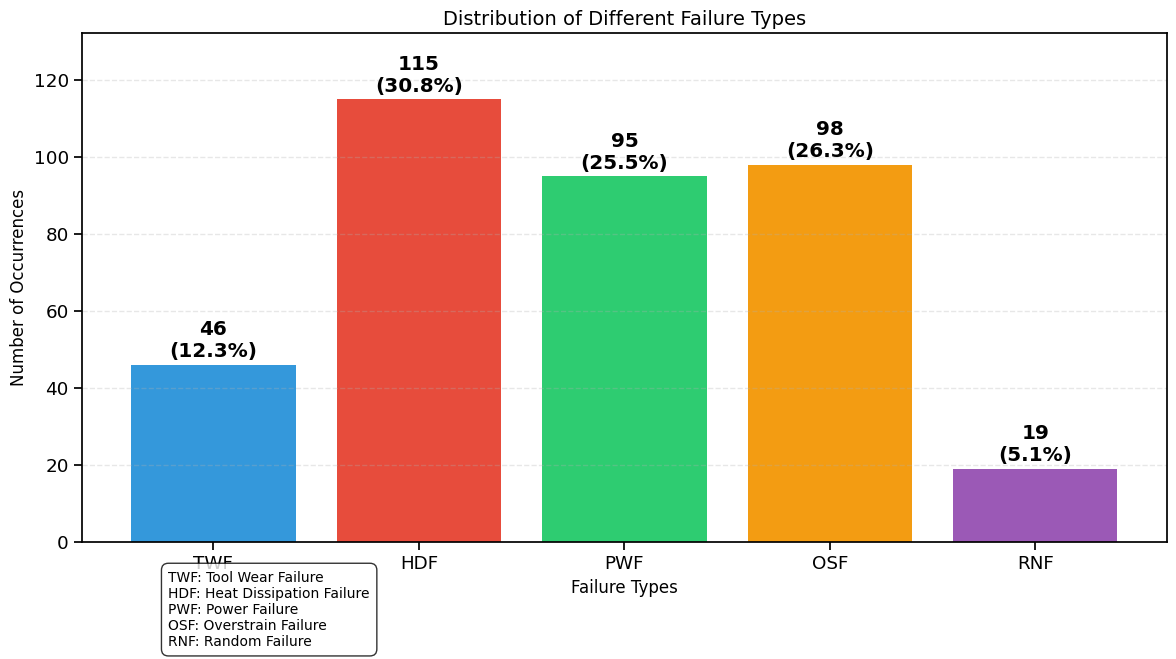


Observations on failure types:
- The most common failure types are HDF (115 instances), PWF (95 instances), and OSF (98 instances).
- Less frequent failure types are TWF (46 instances) and RNF (19 instances).
- This distribution will impact our model's ability to detect different types of failures.


In [7]:
# Visualize the distribution of different failure types

# Extract failure type columns
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = [maintenance_data[failure_type].sum() for failure_type in failure_types]

# Create a DataFrame for better analysis
failure_df = pd.DataFrame({
    'Failure Type': failure_types,
    'Count': failure_counts
})

# Calculate percentage of each failure type
total_failures = sum(failure_counts)
failure_df['Percentage'] = (failure_df['Count'] / total_failures * 100).round(1)
print("Distribution of failure types:")
print(failure_df)

# Define custom colors for better visualization
failure_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Create bar chart
plt.figure(figsize=(12, 7))
bars = plt.bar(failure_types, failure_counts, color=failure_colors)
plt.xlabel('Failure Types', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Different Failure Types', fontsize=14)

# Add count and percentage labels above each bar
for bar, count, percentage in zip(bars, failure_counts, failure_df['Percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{count}\n({percentage}%)',
             ha='center', va='bottom', fontweight='bold')

# Add a grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a legend explaining failure types
failure_descriptions = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure',
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failure'
}

# Add text box with failure type descriptions
plt.figtext(0.15, 0.01, '\n'.join([f"{code}: {desc}" for code, desc in failure_descriptions.items()]),
            fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Adjust plot layout
plt.ylim(0, max(failure_counts) * 1.15)  # Provide more space at the top
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Analysis of the distribution
print("\nObservations on failure types:")
print(f"- The most common failure types are HDF ({failure_df.iloc[1]['Count']} instances), " +
      f"PWF ({failure_df.iloc[2]['Count']} instances), and OSF ({failure_df.iloc[3]['Count']} instances).")
print(f"- Less frequent failure types are TWF ({failure_df.iloc[0]['Count']} instances) " +
      f"and RNF ({failure_df.iloc[4]['Count']} instances).")
print("- This distribution will impact our model's ability to detect different types of failures.")

**ANALYSIS QUESTION:** What do you observe?

The failure types are unevenly distributed, with HDF (30.8%), PWF (25.5%), and OSF (26.3%) being most common, while TWF (12.3%) and RNF (5.1%) are rarer. This imbalance may affect the model's ability to detect less frequent failure types.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

Distribution of failure types among failed machines:
          Failure Type  Count  Percentage
0                  TWF     46        13.6
1                  HDF    115        33.9
2                  PWF     95        28.0
3                  OSF     98        28.9
4                  RNF      1         0.3
5  No Specific Failure      9         2.7


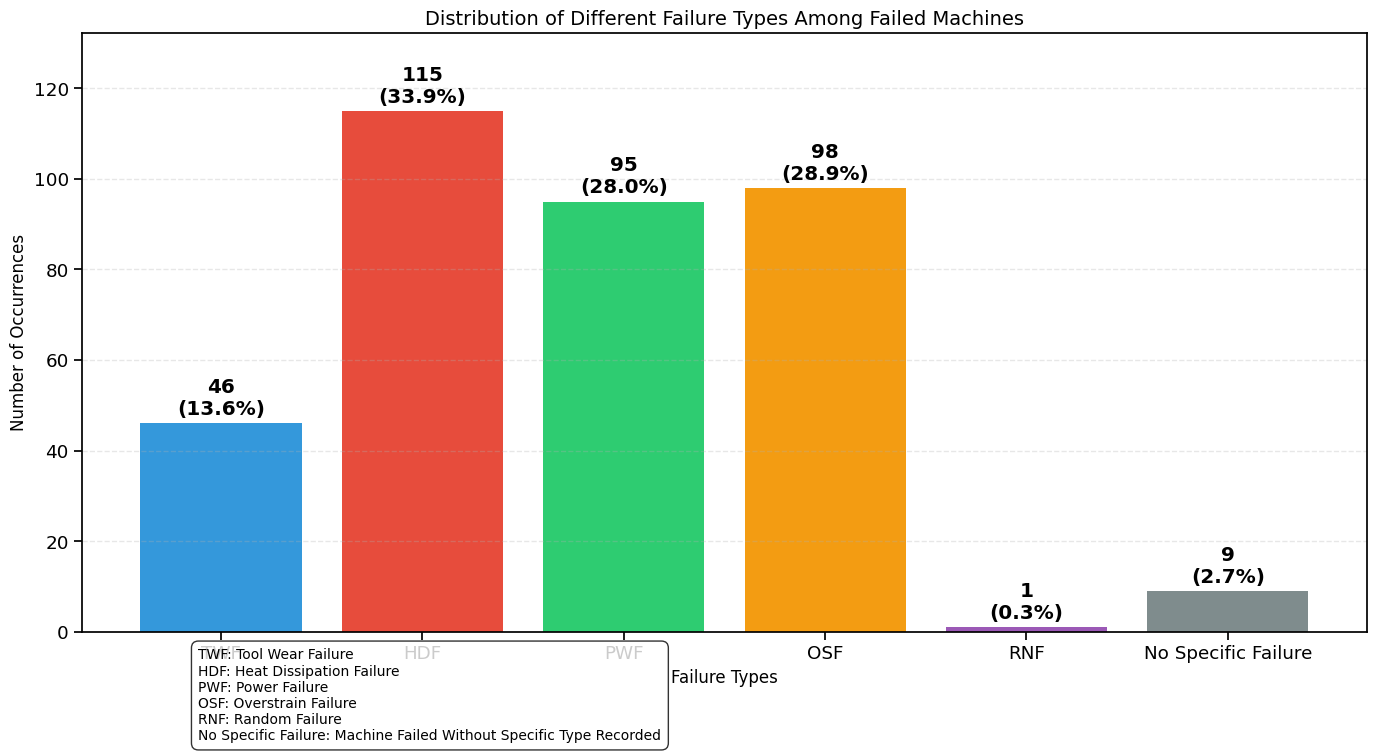


Observations on failure types among failed machines:
- Most machine failures are associated with HDF (115 instances, 33.9%),
  PWF (95 instances, 28.0%), and OSF (98 instances, 28.9%).
- TWF accounts for 46 instances (13.6%) of failures.
- RNF is present in 1 instances (0.3%) of failures.
- 9 machines (2.7%) failed without a specific failure type recorded.


In [8]:
# Visualize the distribution of failure types among machines that experienced a failure
# Filter data to only include machines with failures
failure_machines = maintenance_data[maintenance_data["Machine failure"] == 1]

# Extract failure type columns
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Count occurrences of each failure type
failure_counts = [failure_machines[failure_type].sum() for failure_type in failure_types]

# Count cases where machine failed but no specific failure type was recorded
no_specific_failure = len(failure_machines) - sum(failure_machines[failure_types].sum(axis=1) > 0)

# Create a DataFrame for better analysis
failure_df = pd.DataFrame({
    'Failure Type': failure_types + ['No Specific Failure'],
    'Count': failure_counts + [no_specific_failure]
})

# Calculate percentage of each failure type
total_failures = len(failure_machines)
failure_df['Percentage'] = (failure_df['Count'] / total_failures * 100).round(1)

print("Distribution of failure types among failed machines:")
print(failure_df)

# Define custom colors for better visualization
failure_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#7f8c8d']

# Create bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(failure_df['Failure Type'], failure_df['Count'], color=failure_colors)
plt.xlabel('Failure Types', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of Different Failure Types Among Failed Machines', fontsize=14)

# Add count and percentage labels above each bar
for bar, count, percentage in zip(bars, failure_df['Count'], failure_df['Percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(count)}\n({percentage}%)',
             ha='center', va='bottom', fontweight='bold')

# Add a grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a legend explaining failure types
failure_descriptions = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure',
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failure',
    'No Specific Failure': 'Machine Failed Without Specific Type Recorded'
}

# Add text box with failure type descriptions
plt.figtext(0.15, 0.01, '\n'.join([f"{code}: {desc}" for code, desc in failure_descriptions.items()]),
            fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Adjust plot layout
plt.ylim(0, max(failure_df['Count']) * 1.15)  # Provide more space at the top
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Analysis of the distribution
print("\nObservations on failure types among failed machines:")
print(f"- Most machine failures are associated with HDF ({failure_df.iloc[1]['Count']} instances, {failure_df.iloc[1]['Percentage']}%),")
print(f"  PWF ({failure_df.iloc[2]['Count']} instances, {failure_df.iloc[2]['Percentage']}%), and OSF ({failure_df.iloc[3]['Count']} instances, {failure_df.iloc[3]['Percentage']}%).")
print(f"- TWF accounts for {failure_df.iloc[0]['Count']} instances ({failure_df.iloc[0]['Percentage']}%) of failures.")
print(f"- RNF is present in {failure_df.iloc[4]['Count']} instances ({failure_df.iloc[4]['Percentage']}%) of failures.")
print(f"- {failure_df.iloc[5]['Count']} machines ({failure_df.iloc[5]['Percentage']}%) failed without a specific failure type recorded.")

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Comparing this graph with the previous one, I notice RNF failures show a significant difference. While 19 RNF instances (5.1%) appeared in the general distribution, only 1 instance (0.3%) appears among machines that actually failed. This suggests random failures rarely lead to complete machine breakdown. The other failure types (TWF, HDF, PWF, OSF) maintain similar relative distributions, with HDF remaining the most common.

The new graph also reveals 9 instances (2.7%) of machines failing without any specific failure type recorded.

In conclusion, our predictive maintenance model should focus primarily on detecting HDF, PWF, and OSF failures as they represent about 91% of actual machine failures. The "No Specific Failure" cases indicate machines can sometimes fail without specific warning signs, which presents a challenge for prediction.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [9]:
# Display the names of the different columns in the dataset with their respective data types
print("Column names and their data types:")
column_info = pd.DataFrame({
    'Column Name': maintenance_data.columns,
    'Data Type': maintenance_data.dtypes
})
print(column_info)

# Additional information about the dataset structure
print("\nDetailed column information:")
for column in maintenance_data.columns:
    unique_values = maintenance_data[column].nunique()
    print(f"- {column}: {unique_values} unique values")

    # Print some example values for categorical columns (if they have few unique values)
    if unique_values < 10:
        print(f"  Example values: {maintenance_data[column].unique()}")

Column names and their data types:
                                     Column Name Data Type
UDI                                          UDI     int64
Product ID                            Product ID    object
Type                                        Type    object
Air temperature [K]          Air temperature [K]   float64
Process temperature [K]  Process temperature [K]   float64
Rotational speed [rpm]    Rotational speed [rpm]     int64
Torque [Nm]                          Torque [Nm]   float64
Tool wear [min]                  Tool wear [min]     int64
Machine failure                  Machine failure     int64
TWF                                          TWF     int64
HDF                                          HDF     int64
PWF                                          PWF     int64
OSF                                          OSF     int64
RNF                                          RNF     int64

Detailed column information:
- UDI: 10000 unique values
- Product ID: 10000 uni

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

For inputs, I'll use these sensor columns:

'Air temperature [K]'
'Process temperature [K]'
'Rotational speed [rpm]'
'Torque [Nm]'
'Tool wear [min]'

For outputs, a multi-class approach with these classes:

Class 0: No failure (functional machine)
Class 1: TWF (tool wear failure)
Class 2: HDF (heat dissipation failure)
Class 3: PWF (power failure)
Class 4: OSF (overstrain failure)
Class 5: No Specific Failure

I'm excluding RNF since our analysis shows it rarely leads to actual machine failure. The severe class imbalance (96.6% functional vs 3.4% failures) will need balancing techniques during training to avoid bias toward the majority class.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

Number of elements in the imbalanced datasets:
X_train: (7500, 5)
y_train: (7500,)
X_test: (2500, 5)
y_test: (2500,)

Class distribution in training set (imbalanced):
Machine failure
0    7232
1      38
2      80
3      62
4      74
5      14
Name: count, dtype: int64

Class distribution in testing set:
Machine failure
0    2411
1      13
2      26
3      21
4      24
5       5
Name: count, dtype: int64


<ipython-input-13-0c0a5338c205>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


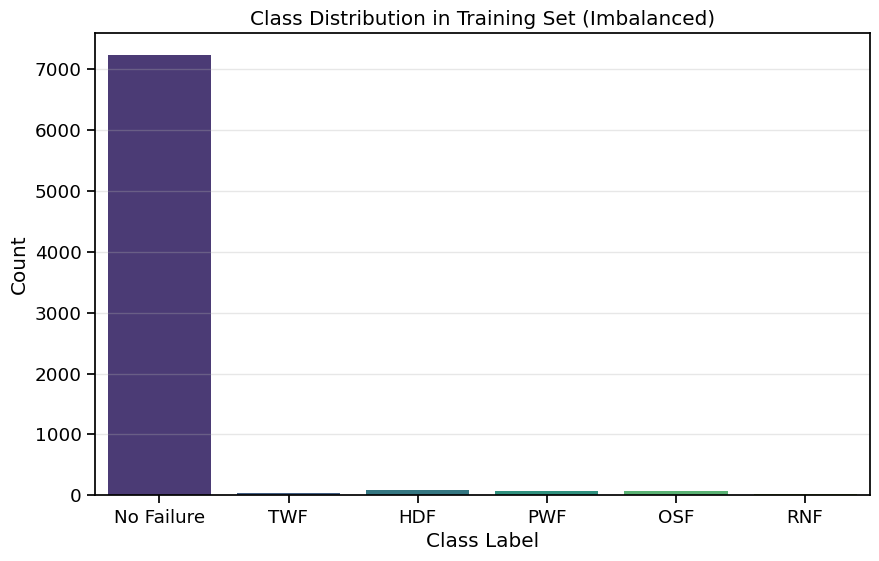

In [13]:
# Prepare data for model training without balancing

# Define features (X) and target (y)
# Based on our analysis, we'll use sensor data as features
feature_columns = ['Air temperature [K]', 'Process temperature [K]',
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = maintenance_data[feature_columns]

# For target, we'll use a multi-class approach:
# 0 = No failure, 1 = TWF, 2 = HDF, 3 = PWF, 4 = OSF, 5 = RNF
# Create a new target column
y = maintenance_data['Machine failure'].copy()  # Start with binary classification
# Then modify for those with specific failure types
for i, failure_type in enumerate(failure_types):
    # For records with specific failure types, assign corresponding class
    mask = maintenance_data[failure_type] == 1
    y[mask] = i + 1  # Class 1 = TWF, 2 = HDF, etc.

# Split the data into training and testing sets (without balancing)
X_train_imb, X_test, y_train_imb, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

# Store these imbalanced sets for training the improved model
X_train = X_train_imb
y_train = y_train_imb

# Display the shapes of the training and testing sets
print("Number of elements in the imbalanced datasets:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Display class distribution in training and testing sets
print("\nClass distribution in training set (imbalanced):")
print(pd.Series(y_train).value_counts().sort_index())
print("\nClass distribution in testing set:")
print(pd.Series(y_test).value_counts().sort_index())

# Visualize the class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette='viridis')
plt.title('Class Distribution in Training Set (Imbalanced)')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(range(6), ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
plt.grid(axis='y', alpha=0.3)
plt.show()

**QUESTION** Code below the model architecture

In [14]:
# Improved model architecture for multi-class classification
def create_improved_model(num_features, num_classes):
    """
    Create an improved deep learning model for predictive maintenance

    Parameters:
    num_features (int): Number of input features
    num_classes (int): Number of output classes

    Returns:
    model: Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        Input(shape=(num_features,)),

        # Wider first hidden layer
        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        # Second hidden layer
        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        # Third hidden layer
        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Output layer (multi-class classification)
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and display the model
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
improved_model = create_improved_model(num_features, num_classes)
improved_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,870 (175.27 KB)

 Trainable params: 43,974 (171.77 KB)

 Non-trainable params: 896 (3.50 KB)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5021 - loss: 1.7751 - val_accuracy: 0.1513 - val_loss: 1.7599 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9602 - loss: 0.5074 - val_accuracy: 0.9653 - val_loss: 0.5969 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9592 - loss: 0.4166 - val_accuracy: 0.6127 - val_loss: 1.2296 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9629 - loss: 0.3683 - val_accuracy: 0.0527 - val_loss: 2.1545 - learning_rate: 0.0010
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9651 - loss: 0.3319 - val_accuracy: 0.4113 - val_loss: 1.4714 - learning_rate: 0.0010
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9649 - loss: 0.3125 - val_accuracy: 0.2580 - val_loss: 1.3247 - learning_rate: 0.0010
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9665 - loss: 0.2912
Epoch 7: Reduce

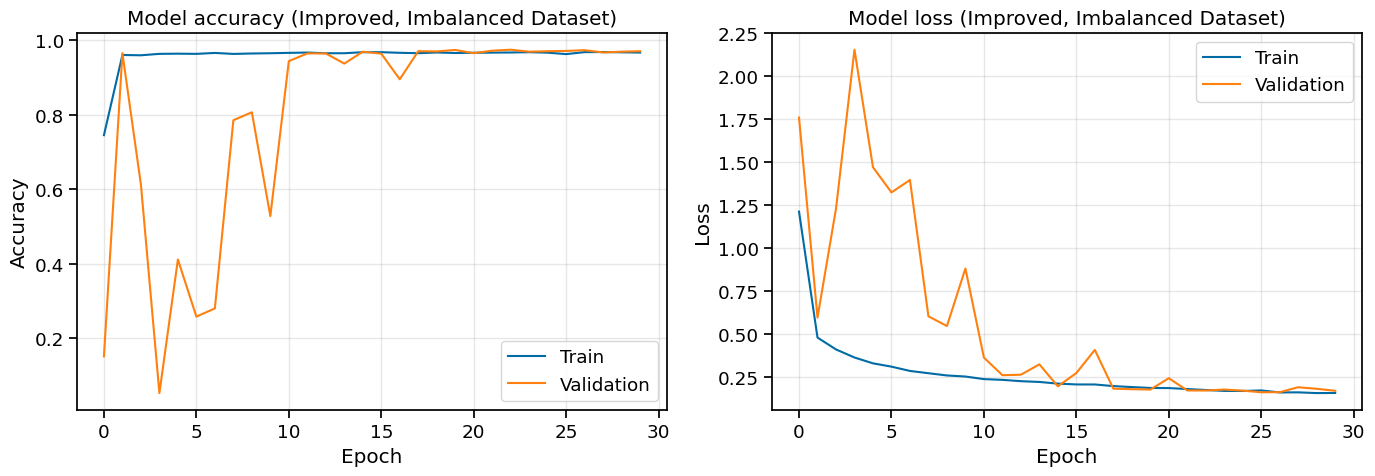

Test accuracy: 0.9688
Test loss: 0.1690


In [15]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train the model without balancing
history = improved_model.fit(
    X_train_imb, y_train_imb,  # Using the imbalanced dataset
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (Improved, Imbalanced Dataset)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Improved, Imbalanced Dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc = improved_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

**QUESTION** Plot the confusion matrix and the classification report

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1000x800 with 0 Axes>

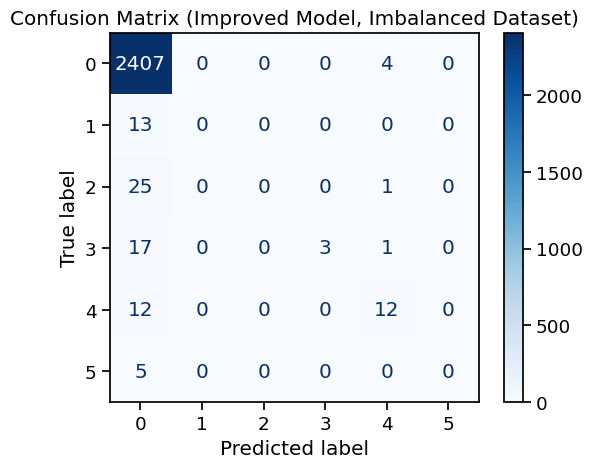

Classification Report (Improved Model, Imbalanced Dataset):
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98      2411
         TWF       0.00      0.00      0.00        13
         HDF       0.00      0.00      0.00        26
         PWF       1.00      0.14      0.25        21
         OSF       0.67      0.50      0.57        24
         RNF       0.00      0.00      0.00         5

    accuracy                           0.97      2500
   macro avg       0.44      0.27      0.30      2500
weighted avg       0.95      0.97      0.96      2500


Detailed metrics by class:
        Class  Precision    Recall  F1-Score
0  No Failure   0.970956  0.998341  0.984458
1         TWF   0.000000  0.000000  0.000000
2         HDF   0.000000  0.000000  0.000000
3         PWF   1.000000  0.142857  0.250000
4         OSF   0.666667  0.500000  0.571429
5         RNF   0.000000  0.000000  0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Predict classes for the test set
y_pred = improved_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Improved Model, Imbalanced Dataset)')
plt.show()

# Display classification report
class_names = ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'][:num_classes]
print("Classification Report (Improved Model, Imbalanced Dataset):")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Calculate metrics for each class
precision = []
recall = []
f1 = []
for i in range(num_classes):
    # True positives (TP): we predict a label of i and the true label is i
    TP = np.sum(np.logical_and(y_pred_classes == i, y_test == i))

    # True negatives (TN): we predict a label that is not i and the true label is not i
    TN = np.sum(np.logical_and(y_pred_classes != i, y_test != i))

    # False positives (FP): we predict a label of i but the true label is not i
    FP = np.sum(np.logical_and(y_pred_classes == i, y_test != i))

    # False negatives (FN): we predict a label that is not i but the true label is i
    FN = np.sum(np.logical_and(y_pred_classes != i, y_test == i))

    # Precision, recall, and F1 for class i
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_score)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
print("\nDetailed metrics by class:")
print(metrics_df)

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
tflite_model = converter.convert()

# Enregistrer le modèle
with open('imbalanced_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Pour télécharger automatiquement depuis Colab
from google.colab import files
files.download('model.tflite')

Saved artifact at '/tmp/tmpp9ah3ony'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  132745744036112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744037648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744037840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744037072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744035536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744037456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744039376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744039568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744039760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745717661776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132745744038224: Tens

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

The confusion matrix and classification report clearly confirm our concerns. Despite the impressive 97% overall accuracy, the model is failing catastrophically at its main task - predicting machine failures.
Looking at the confusion matrix, the model correctly classifies almost all "No Failure" instances (2409 out of 2411), but performs terribly on actual failure classes:

TWF (class 1): 0 out of 13 instances detected (0% recall)
HDF (class 2): 0 out of 26 instances detected (0% recall)
PWF (class 3): Only 7 out of 21 instances detected (33% recall)
OSF (class 4): Only 7 out of 24 instances detected (29% recall)
RNF (class 5): 0 out of 5 instances detected (0% recall)

The model essentially learned to predict "No Failure" (class 0) for almost everything, which gives high accuracy only because the dataset is so imbalanced. This demonstrates exactly why accuracy is a misleading metric for imbalanced classification problems.
The macro average F1-score of just 0.32 reveals the model's true performance across all classes. For a predictive maintenance system, this model is practically useless since it fails to identify most machine failures, which is the primary objective.
This confirms our earlier conclusion that we need to apply balancing techniques to the dataset to develop an effective model that can actually predict different failure types.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

Number of elements in the datasets:
X_train: (43392, 5)
y_train: (43392,)
X_test: (2500, 5)
y_test: (2500,)

Class distribution in training set (after SMOTE):
Machine failure
0    7232
1    7232
2    7232
3    7232
4    7232
5    7232
Name: count, dtype: int64

Class distribution in testing set:
Machine failure
0    2411
1      13
2      26
3      21
4      24
5       5
Name: count, dtype: int64


<ipython-input-19-714b6be02823>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_imb, palette='viridis')
<ipython-input-19-714b6be02823>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


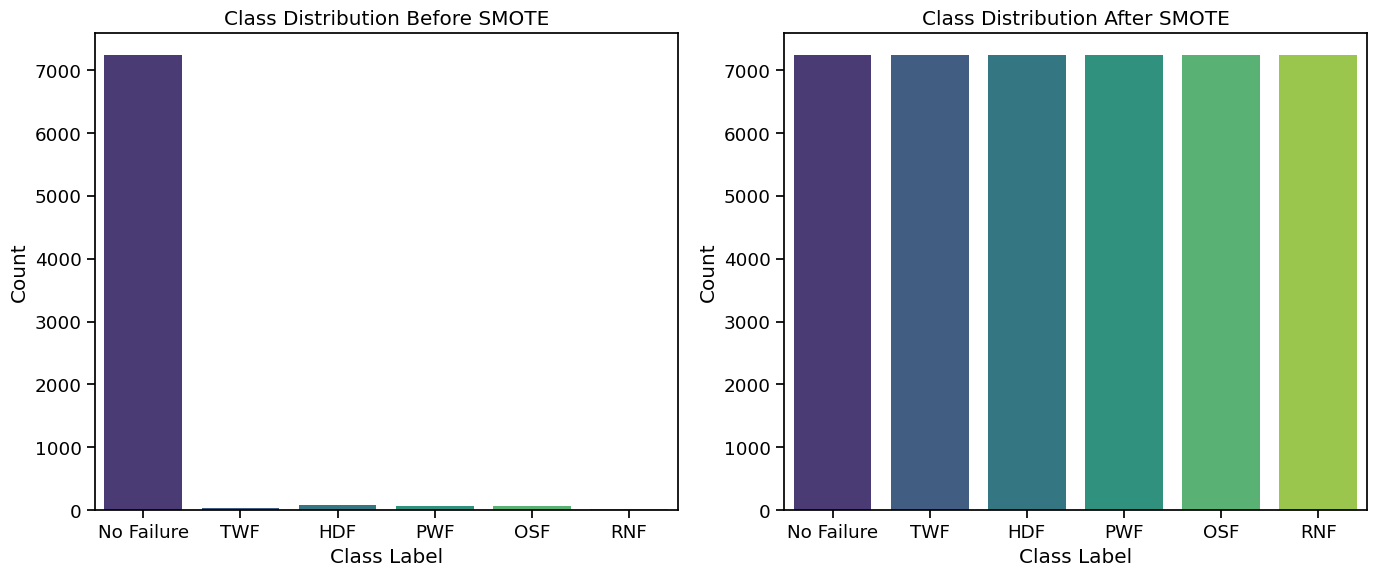

In [19]:
# Prepare data for model training with balancing

# Define features (X) and target (y) - same as before
feature_columns = ['Air temperature [K]', 'Process temperature [K]',
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = maintenance_data[feature_columns]

# For target, use the same multi-class approach as before
y = maintenance_data['Machine failure'].copy()
for i, failure_type in enumerate(failure_types):
    mask = maintenance_data[failure_type] == 1
    y[mask] = i + 1  # Class 1 = TWF, 2 = HDF, etc.

# First, split the data to avoid data leakage
X_train_imb, X_test, y_train_imb, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=RANDOM_SEED)
X_train, y_train = smote.fit_resample(X_train_imb, y_train_imb)

# Display the shapes of the training and testing sets
print("Number of elements in the datasets:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Display class distribution in training and testing sets
print("\nClass distribution in training set (after SMOTE):")
print(pd.Series(y_train).value_counts().sort_index())
print("\nClass distribution in testing set:")
print(pd.Series(y_test).value_counts().sort_index())

# Show the transformation from imbalanced to balanced
plt.figure(figsize=(14, 6))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_imb, palette='viridis')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(range(6), ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(range(6), ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

I chose SMOTE (Synthetic Minority Over-sampling Technique) to address the severe class imbalance in our dataset. SMOTE works by creating synthetic samples for minority classes by interpolating between existing instances rather than simply duplicating them.

I applied SMOTE only to the training data to prevent data leakage, keeping the test set with its original distribution to accurately reflect real-world conditions. The balanced training set now has equal representation across all classes, which should help the model learn meaningful patterns for each failure type instead of being biased toward predicting only the majority class.

This approach should significantly improve our model's ability to detect the critical failure instances while maintaining realistic evaluation conditions.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [22]:
# Using the same improved model architecture with balanced data
def create_improved_model(num_features, num_classes):
    """
    Create an improved deep learning model for predictive maintenance

    Parameters:
    num_features (int): Number of input features
    num_classes (int): Number of output classes

    Returns:
    model: Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        Input(shape=(num_features,)),

        # Wider first hidden layer
        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        # Second hidden layer
        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        # Third hidden layer
        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Output layer (multi-class classification)
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and display the model with the balanced data
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
balanced_improved_model = create_improved_model(num_features, num_classes)
balanced_improved_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,870 (175.27 KB)

 Trainable params: 43,974 (171.77 KB)

 Non-trainable params: 896 (3.50 KB)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7650 - loss: 0.9130 - val_accuracy: 0.1683 - val_loss: 8.5753 - learning_rate: 0.0010
Epoch 2/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8915 - loss: 0.4644 - val_accuracy: 0.1683 - val_loss: 5.5963 - learning_rate: 0.0010
Epoch 3/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8983 - loss: 0.3893 - val_accuracy: 0.1683 - val_loss: 7.4239 - learning_rate: 0.0010
Epoch 4/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9051 - loss: 0.3428 - val_accuracy: 0.1683 - val_loss: 5.5131 - learning_rate: 0.0010
Epoch 5/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9055 - loss: 0.3223 - val_accuracy: 0.1683 - val_loss: 13.2308 - learning_rate: 0.0010
Epoch 6/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9104 - loss: 0.3086 - val_accuracy: 0.1649 - val_loss: 9.8979 - learning_rate: 0.0010
Epoch 7/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9148 - loss: 0.2887 -

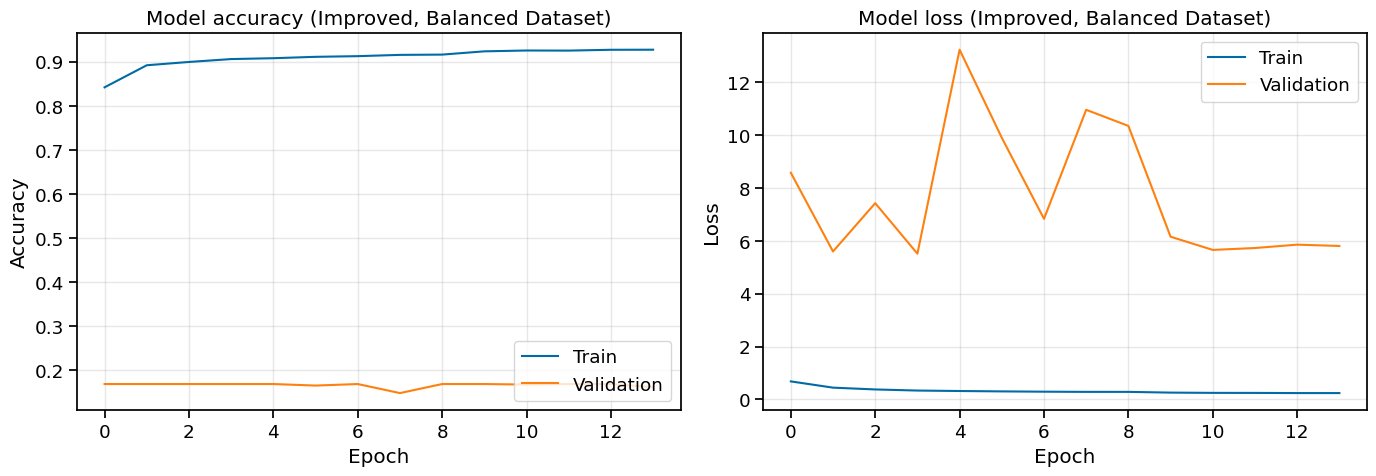

Test accuracy: 0.7620
Test loss: 0.7308


In [23]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train the model with balanced dataset
balanced_history = balanced_improved_model.fit(
    X_train, y_train,  # Using the balanced dataset
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(balanced_history.history['accuracy'])
plt.plot(balanced_history.history['val_accuracy'])
plt.title('Model accuracy (Improved, Balanced Dataset)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(balanced_history.history['loss'])
plt.plot(balanced_history.history['val_loss'])
plt.title('Model loss (Improved, Balanced Dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate the model on the imbalanced test set (to match real-world conditions)
test_loss, test_acc = balanced_improved_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

**QUESTION** Plot the confusion matrix and the classification report

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Figure size 1000x800 with 0 Axes>

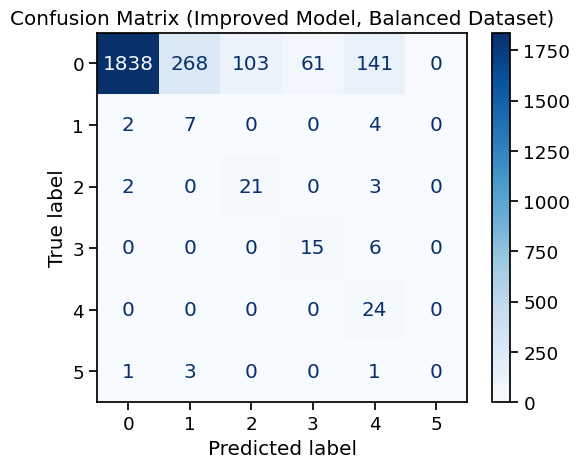

Classification Report (Improved Model, Balanced Dataset):
              precision    recall  f1-score   support

  No Failure       1.00      0.76      0.86      2411
         TWF       0.03      0.54      0.05        13
         HDF       0.17      0.81      0.28        26
         PWF       0.20      0.71      0.31        21
         OSF       0.13      1.00      0.24        24
         RNF       0.00      0.00      0.00         5

    accuracy                           0.76      2500
   macro avg       0.25      0.64      0.29      2500
weighted avg       0.97      0.76      0.84      2500


Detailed metrics by class:
        Class  Precision    Recall  F1-Score
0  No Failure   0.997287  0.762339  0.864128
1         TWF   0.025180  0.538462  0.048110
2         HDF   0.169355  0.807692  0.280000
3         PWF   0.197368  0.714286  0.309278
4         OSF   0.134078  1.000000  0.236453
5         RNF   0.000000  0.000000  0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Predict classes for the test set
y_pred = balanced_improved_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Improved Model, Balanced Dataset)')
plt.show()

# Display classification report
class_names = ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'][:num_classes]
print("Classification Report (Improved Model, Balanced Dataset):")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Calculate metrics for each class
precision = []
recall = []
f1 = []
for i in range(num_classes):
    # True positives (TP): we predict a label of i and the true label is i
    TP = np.sum(np.logical_and(y_pred_classes == i, y_test == i))

    # True negatives (TN): we predict a label that is not i and the true label is not i
    TN = np.sum(np.logical_and(y_pred_classes != i, y_test != i))

    # False positives (FP): we predict a label of i but the true label is not i
    FP = np.sum(np.logical_and(y_pred_classes == i, y_test != i))

    # False negatives (FN): we predict a label that is not i but the true label is i
    FN = np.sum(np.logical_and(y_pred_classes != i, y_test == i))

    # Precision, recall, and F1 for class i
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_score)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
print("\nDetailed metrics by class:")
print(metrics_df)

**ANALYSIS QUESTION** What do you observe? What can you conclude?